# StockX Transaction Data Light GBM Model (All shoes)

In [1]:
import requests
from bs4 import BeautifulSoup as bs4
import re
import json
import time
from datetime import datetime, timedelta
import pandas as pd
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm import tqdm
import stockx_util as x
base_url = 'https://stockx.com'
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

In [2]:
all_trans_and_shoes = pd.read_csv('all_trans_and_shoe.csv')
all_trans_and_shoes['createdAt'] = pd.to_datetime(all_trans_and_shoes['createdAt']).dt.tz_localize(None)
all_trans_and_shoes['release_date'] = pd.to_datetime(all_trans_and_shoes['release_date']).dt.tz_localize(None)
all_trans_and_shoes['d_release'] = pd.to_timedelta(all_trans_and_shoes['d_release'])

all_trans_and_shoes.index = all_trans_and_shoes['createdAt']
del all_trans_and_shoes['createdAt']
del all_trans_and_shoes['createdAt.1']

/Users/tsofoon/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
all_trans_and_shoes.head()

,name,model,color1,color2,release_date,description,product_name,shoe_size,amount,localAmount,localCurrency,specialSize,chainId,d_release
createdAt,,,,,,,,,,,,,,
2012-05-02 08:00:00,Jordan 3 Retro Black Cement (2011),Jordan 3 Retro,Black,Cement Grey-White-Varsity Red,2011-11-25,Any year that an Air Jordan 3 releases is a go...,Jordan 3 Retro Black Cement (2011),11.0,260.0,260.0,"USD""",NaN,12141374140158606740,159 days 08:00:00
2012-05-08 02:00:00,Jordan 11 Retro Concord (2011),Jordan 11 Retro,White,Black-Dark Concord,2011-12-23,NaN,Jordan 11 Retro Concord (2011),9.0,375.0,375.0,"USD""",NaN,12141374353518083120,137 days 02:00:00
2012-05-11 05:00:00,Jordan 11 Retro Concord (2011),Jordan 11 Retro,White,Black-Dark Concord,2011-12-23,NaN,Jordan 11 Retro Concord (2011),10.0,320.0,320.0,"USD""",NaN,12129127424375900296,140 days 05:00:00
2012-05-16 19:00:00,Jordan 4 Retro Doernbecher,Jordan 4 Retro,Black,Old Royal-Electric Green-White,2011-11-08,NaN,Jordan 4 Retro Doernbecher,9.0,800.0,800.0,"USD""",NaN,12140006752700573816,190 days 19:00:00
2012-05-17 01:00:00,Jordan 4 Retro Doernbecher,Jordan 4 Retro,Black,Old Royal-Electric Green-White,2011-11-08,NaN,Jordan 4 Retro Doernbecher,11.5,1060.0,1060.0,"USD""",NaN,12140011241238831758,191 days 01:00:00


In [4]:
all_trans_and_shoes['createdAt'] = all_trans_and_shoes.index

In [5]:
all_trans_and_shoes = all_trans_and_shoes[pd.isnull(all_trans_and_shoes['specialSize'])]

In [6]:
all_trans_and_shoes.notna().sum()

name             4524511
model            4524511
color1           4524511
color2           4510266
release_date     4524511
description      3574433
product_name     4524511
shoe_size        4524511
amount           4524511
localAmount      4524511
localCurrency    4524511
specialSize            0
chainId          4524511
d_release        4524511
createdAt        4524511
dtype: int64

In [7]:
# currently unused
def get_df_future(df, p_name, size, start_time, days_delta):
    df = df[df.index >= start_time]
    end_time = start_time + timedelta(days = days_delta)
    df = df[df.index <= end_time]
    return df[(df['product_name']==p_name)&(df['shoe_size']==size)]

In [8]:
len(all_trans_and_shoes)

4524511

In [9]:
del all_trans_and_shoes['specialSize']

In [10]:
def get_future_price_change(df, days_delta, thres):
    if thres < 0:
        col_name = 'drop'+str(abs(thres))+'_'+str(days_delta)+'d'
    else:
        col_name = 'raise'+str(thres)+'_'+str(days_delta)+'d'
    out_df = pd.DataFrame(columns = df.columns)
    out_df[col_name] = False
    for p in tqdm(df['product_name'].unique()):
        shoe_df_all_sizes = pd.DataFrame(columns = out_df.columns)
        for s in df[df['product_name']==p]['shoe_size'].unique():
            shoe_df = df[(df['product_name']==p)&(df['shoe_size']==s)]
            if thres < 0:
                shoe_df_day = shoe_df['amount'].resample('D').min()
                shoe_df_day = shoe_df_day.fillna(method = 'bfill')
                shoe_df_day = shoe_df_day.rolling(days_delta,min_periods = 1).min()
            else:
                shoe_df_day = shoe_df['amount'].resample('D').max()
                shoe_df_day = shoe_df_day.fillna(method = 'bfill')
                shoe_df_day = shoe_df_day.rolling(days_delta,min_periods = 1).max()
            #print(len(shoe_df), len(shoe_df_day))
            shoe_df = pd.merge_asof(shoe_df, shoe_df_day, left_index = True, right_index = True)
            shoe_df = shoe_df.rename(columns={'amount_x':'amount'})
            if thres < 0:
                shoe_df[col_name] = shoe_df['amount']*((100+thres)/100) >= shoe_df['amount_y']
            else:
                shoe_df[col_name] = shoe_df['amount']*((100+thres)/100) <= shoe_df['amount_y']
            del shoe_df['amount_y']
            shoe_df_all_sizes = shoe_df_all_sizes.append(shoe_df)
        out_df = out_df.append(shoe_df_all_sizes)
    return out_df

In [13]:
len(all_trans_and_shoes)

4524511

In [14]:
all_trans_and_shoes = get_future_price_change(all_trans_and_shoes, 60, -10) # drop -10% in 60 days
all_trans_and_shoes = get_future_price_change(all_trans_and_shoes, 60, 10) # drop -10% in 60 days


 21%|██▏       | 155/725 [07:27<35:04,  3.69s/it]


 43%|████▎     | 309/725 [17:35<32:04,  4.63s/it]


 64%|██████▍   | 463/725 [30:31<21:36,  4.95s/it]


 85%|████████▌ | 617/725 [44:41<10:30,  5.84s/it]


100%|██████████| 725/725 [54:01<00:00,  4.47s/it]

  6%|▋         | 46/725 [01:59<29:19,  2.59s/it]


 28%|██▊       | 201/725 [09:45<33:57,  3.89s/it]


 49%|████▉     | 355/725 [20:57<26:10,  4.24s/it]


 70%|███████   | 509/725 [34:45<16:58,  4.71s/it]


 91%|█████████▏| 663/725 [49:13<05:54,  5.71s/it]


100%|██████████| 725/725 [54:34<00:00,  4.52s/it]


In [15]:
all_trans_and_shoes.head()

,name,model,color1,color2,release_date,description,product_name,shoe_size,amount,localAmount,localCurrency,chainId,d_release,createdAt,drop10_60d,raise10_60d
2012-05-02 08:00:00,Jordan 3 Retro Black Cement (2011),Jordan 3 Retro,Black,Cement Grey-White-Varsity Red,2011-11-25,Any year that an Air Jordan 3 releases is a go...,Jordan 3 Retro Black Cement (2011),11.0,260.0,260.0,"USD""",12141374140158606740,159 days 08:00:00,2012-05-02 08:00:00,False,False
2012-07-12 04:00:00,Jordan 3 Retro Black Cement (2011),Jordan 3 Retro,Black,Cement Grey-White-Varsity Red,2011-11-25,Any year that an Air Jordan 3 releases is a go...,Jordan 3 Retro Black Cement (2011),11.0,215.0,215.0,"USD""",12129126184940125086,230 days 04:00:00,2012-07-12 04:00:00,False,False
2013-08-28 22:00:00,Jordan 3 Retro Black Cement (2011),Jordan 3 Retro,Black,Cement Grey-White-Varsity Red,2011-11-25,Any year that an Air Jordan 3 releases is a go...,Jordan 3 Retro Black Cement (2011),11.0,290.0,290.0,"USD""",12141375274833198363,642 days 22:00:00,2013-08-28 22:00:00,False,False
2013-11-26 03:00:00,Jordan 3 Retro Black Cement (2011),Jordan 3 Retro,Black,Cement Grey-White-Varsity Red,2011-11-25,Any year that an Air Jordan 3 releases is a go...,Jordan 3 Retro Black Cement (2011),11.0,295.0,295.0,"USD""",12141378501860460324,732 days 03:00:00,2013-11-26 03:00:00,False,False
2014-02-15 14:00:00,Jordan 3 Retro Black Cement (2011),Jordan 3 Retro,Black,Cement Grey-White-Varsity Red,2011-11-25,Any year that an Air Jordan 3 releases is a go...,Jordan 3 Retro Black Cement (2011),11.0,405.0,405.0,"USD""",12129128831095153371,813 days 14:00:00,2014-02-15 14:00:00,False,False


In [16]:
def get_up_n_down(df):
    df['price_change'] = 0
    up = df.columns[df.columns.str.startswith('raise')][0]
    down = df.columns[df.columns.str.startswith('drop')][0]
    df.loc[df[up] == 1,'price_change'] = 1
    df.loc[df[down] == 1,'price_change'] = -1
    
    return df

In [17]:
from sklearn.preprocessing import LabelEncoder

def preprocessing(df, lbl_columns):
    lbl_dict = {}
    for c in tqdm(lbl_columns):
        
        if df[c].dtype == 'object':

            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            lbl_dict[c] = lbl
            df[c] = lbl.transform(list(df[c].values))
    return df, lbl_dict

In [18]:
lbl_columns = ['model', 'product_name','color1', 'color2']#, 'specialSize']
all_trans_and_shoes_lbl, lbl_dict = \
    preprocessing(all_trans_and_shoes, lbl_columns)



100%|██████████| 4/4 [00:33<00:00,  8.27s/it]


In [19]:
lbl_dict

{'model': LabelEncoder(),
 'product_name': LabelEncoder(),
 'color1': LabelEncoder(),
 'color2': LabelEncoder()}

In [20]:
all_trans_and_shoes_lbl.head()

,name,model,color1,color2,release_date,description,product_name,shoe_size,amount,localAmount,localCurrency,chainId,d_release,createdAt,drop10_60d,raise10_60d
2012-05-02 08:00:00,Jordan 3 Retro Black Cement (2011),40,17,126,2011-11-25,Any year that an Air Jordan 3 releases is a go...,204,11.0,260.0,260.0,"USD""",12141374140158606740,159 days 08:00:00,2012-05-02 08:00:00,False,False
2012-07-12 04:00:00,Jordan 3 Retro Black Cement (2011),40,17,126,2011-11-25,Any year that an Air Jordan 3 releases is a go...,204,11.0,215.0,215.0,"USD""",12129126184940125086,230 days 04:00:00,2012-07-12 04:00:00,False,False
2013-08-28 22:00:00,Jordan 3 Retro Black Cement (2011),40,17,126,2011-11-25,Any year that an Air Jordan 3 releases is a go...,204,11.0,290.0,290.0,"USD""",12141375274833198363,642 days 22:00:00,2013-08-28 22:00:00,False,False
2013-11-26 03:00:00,Jordan 3 Retro Black Cement (2011),40,17,126,2011-11-25,Any year that an Air Jordan 3 releases is a go...,204,11.0,295.0,295.0,"USD""",12141378501860460324,732 days 03:00:00,2013-11-26 03:00:00,False,False
2014-02-15 14:00:00,Jordan 3 Retro Black Cement (2011),40,17,126,2011-11-25,Any year that an Air Jordan 3 releases is a go...,204,11.0,405.0,405.0,"USD""",12129128831095153371,813 days 14:00:00,2014-02-15 14:00:00,False,False


In [21]:
start = datetime(2016,1,1)
t0 = datetime(2019,7,1)
t1 = datetime(2019,9,1)
t2 = datetime(2019,11,1)
t3 = datetime(2020,1,1)

old0, future0 = x.split_ts(all_trans_and_shoes_lbl, start,t0,t1)
old1, future1 = x.split_ts(all_trans_and_shoes_lbl, start,t1,t2)
old2, future2 = x.split_ts(all_trans_and_shoes_lbl,start, t2,t3)
old3, _ = x.split_ts(all_trans_and_shoes_lbl,start, t3,t3)

In [22]:
old0_df = x.get_last_transaction(old0)
old1_df = x.get_last_transaction(old1)
old2_df = x.get_last_transaction(old2)
old3_df = x.get_last_transaction(old2)
future0_df = x.get_last_transaction(future0)
future1_df = x.get_last_transaction(future1)
future2_df = x.get_last_transaction(future2)

#future0_df = x.get_historic_transaction(old0_df, future0)
#future1_df = x.get_historic_transaction(old1_df, future1)
#future2_df = x.get_historic_transaction(old2_df, future2)
old0_df = x.parse_old_df(old0_df)
old1_df = x.parse_old_df(old1_df)
old2_df = x.parse_old_df(old2_df)
old3_df = x.parse_old_df(old3_df)
future0_df = x.parse_old_df(future0_df)
future1_df = x.parse_old_df(future1_df)
future2_df = x.parse_old_df(future2_df)


#future0_df = x.parse_future_df(future0_df)
#future1_df = x.parse_future_df(future1_df)
#future2_df = x.parse_future_df(future2_df)


  0%|          | 0/442 [00:00<?, ?it/s]/Users/tsofoon/PycharmProjects/stockx/stockx_util.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['last_amount_same_size'] = tmp['amount'].shift(periods=1)
/Users/tsofoon/PycharmProjects/stockx/stockx_util.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['last_createdAt_same_size'] = tmp['createdAt'].shift(periods=1)
/Users/tsofoon/PycharmProjects/stockx/stockx_util.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

 65%|██████▍   | 287/442 [03:24<04:00,  1.55s/it]


100%|█████████▉| 441/442 [09:06<00:02,  2.13s/it]


100%|██████████| 442/442 [09:08<00:00,  1.24s/it]

 32%|███▏      | 155/482 [01:06<03:44,  1.46it/s]


 64%|██████▍   | 309/482 [04:11<05:15,  1.82s/it]


 96%|█████████▌| 463/482 [10:49<00:54,  2.87s/it]


100%|██████████| 482/482 [11:40<00:00,  1.45s/it]

 26%|██▌       | 137/524 [01:00<04:00,  1.61it/s]


 56%|█████▌    | 291/524 [03:51<06:48,  1.75s/it]


 85%|████████▍ | 445/524 [10:36<04:07,  3.13s/it]


100%|██████████| 524/524 [14:49<00:00,  1.70s/it]

 15%|█▍        | 77/524 [00:27<02:25,  3.08it/s]


 44%|████▍     | 232/524 [02:20<04:50,  1.01it/s]


 74%|███████▎  | 386/524 [07:32<06:31,  2.84s/it]


100%|██████████| 524/524 [14:42<00:00,  1.68s/it]

  6%|▌         | 26/447 [00:03<00:44,  9.54it/s]


 50%|█████     | 225/447 [00:44<01:07,  3.30it/s]


 85%|████████▍ | 379/447 [01:54<00:42,  1.60it/s]


100%|██████████| 447/447 [02:37<00:00,  2.84it/s]

 26%|██▌       | 124/483 [00:18<01:03,  5.61it/s]


 60%|██████    | 292/483 [01:09<01:17,  2.47it/s]


 92%|█████████▏| 446/483 [02:29<00:26,  1.40it/s]


100%|██████████| 483/483 [02:51<00:00,  2.81it/s]

 34%|███▎      | 179/531 [00:30<02:22,  2.47it/s]


 63%|██████▎   | 333/531 [01:30<01:42,  1.93it/s]


 92%|█████████▏| 487/531 [03:12<00:41,  1.05it/s]


100%|██████████| 531/531 [03:49<00:00,  2.31it/s]


In [23]:
future1_df.index = future1_df['createdAt']
future2_df.index = future2_df['createdAt']
old0_df_to_lgb = x.convert_time(old0_df)
old1_df_to_lgb = x.convert_time(old1_df)
old2_df_to_lgb = x.convert_time(old2_df)
old3_df_to_lgb = x.convert_time(old3_df)

future0_df_to_lgb = x.convert_time(future0_df)
future1_df_to_lgb = x.convert_time(future1_df)
future2_df_to_lgb = x.convert_time(future2_df)
old0_df_to_lgb = old0_df_to_lgb.apply(pd.to_numeric, errors='ignore')
old1_df_to_lgb = old1_df_to_lgb.apply(pd.to_numeric, errors='ignore')
old2_df_to_lgb = old2_df_to_lgb.apply(pd.to_numeric, errors='ignore')
old3_df_to_lgb = old3_df_to_lgb.apply(pd.to_numeric, errors='ignore')

future0_df_to_lgb = future0_df_to_lgb.apply(pd.to_numeric, errors='ignore')
future1_df_to_lgb = future1_df_to_lgb.apply(pd.to_numeric, errors='ignore')
future2_df_to_lgb = future2_df_to_lgb.apply(pd.to_numeric, errors='ignore')

2016-01-01 00:00:00    1
2016-01-01 00:00:00    1
2016-01-01 00:00:00    1
2016-01-01 00:00:00    1
2016-01-01 01:00:00    1
Name: createdAt, dtype: int64
do nothing
2016-01-01 00:00:00    1
2016-01-01 00:00:00    1
2016-01-01 00:00:00    1
2016-01-01 00:00:00    1
2016-01-01 01:00:00    1
Name: createdAt, dtype: int64
do nothing
2016-01-01 00:00:00    1
2016-01-01 00:00:00    1
2016-01-01 00:00:00    1
2016-01-01 00:00:00    1
2016-01-01 01:00:00    1
Name: createdAt, dtype: int64
do nothing
2016-01-01 00:00:00    1
2016-01-01 00:00:00    1
2016-01-01 00:00:00    1
2016-01-01 00:00:00    1
2016-01-01 01:00:00    1
Name: createdAt, dtype: int64
do nothing
2019-07-01    7
2019-07-01    7
2019-07-01    7
2019-07-01    7
2019-07-01    7
Name: createdAt, dtype: int64
do nothing
createdAt
2019-09-01    9
2019-09-01    9
2019-09-01    9
2019-09-01    9
2019-09-01    9
Name: createdAt, dtype: int64
do nothing
createdAt
2019-11-01    11
2019-11-01    11
2019-11-01    11
2019-11-01    11
2019-1

In [24]:
old0_df_to_lgb.to_csv('old0_df_to_lgb_all_shoes_classify_down10_up10.csv')
old1_df_to_lgb.to_csv('old1_df_to_lgb_all_shoes_classify_down10_up10.csv')
old2_df_to_lgb.to_csv('old2_df_to_lgb_all_shoes_classify_down10_up10.csv')
old3_df_to_lgb.to_csv('old3_df_to_lgb_all_shoes_classify_down10_up10.csv')

future0_df_to_lgb.to_csv('future0_df_to_lgb_all_shoes_classify_down10_up10.csv')
future1_df_to_lgb.to_csv('future1_df_to_lgb_all_shoes_classify_down10_up10.csv')
future2_df_to_lgb.to_csv('future2_df_to_lgb_all_shoes_classify_down10_up10.csv')

In [25]:
old0_df_to_lgb.columns

Index(['model', 'color1', 'color2', 'product_name', 'shoe_size', 'amount',
       'drop10_60d', 'raise10_60d', 'last_amount_same_size',
       'median_daily_amount_same_size',
       'median_daily_amount_same_size_3d_rolling_avg',
       'median_daily_amount_same_size_5d_rolling_avg',
       'median_daily_amount_same_size_7d_rolling_avg',
       'median_daily_amount_same_size_14d_rolling_avg',
       'median_daily_amount_same_size_21d_rolling_avg',
       'median_daily_amount_same_size_30d_rolling_avg',
       'median_daily_amount_same_size_60d_rolling_avg', 'last_amount_any_size',
       'last_shoe_size_any_size', 'median_daily_amount_any_size',
       'median_daily_amount_any_size_3d_rolling_avg',
       'median_daily_amount_any_size_5d_rolling_avg',
       'median_daily_amount_any_size_7d_rolling_avg',
       'median_daily_amount_any_size_14d_rolling_avg',
       'median_daily_amount_any_size_21d_rolling_avg',
       'median_daily_amount_any_size_30d_rolling_avg',
       'median_dai

In [27]:
print(old0_df_to_lgb['drop10_60d'].value_counts(),'\n',\
old1_df_to_lgb['drop10_60d'].value_counts(),'\n',\
old2_df_to_lgb['drop10_60d'].value_counts())

print(future0_df_to_lgb['drop10_60d'].value_counts(),'\n',\
future1_df_to_lgb['drop10_60d'].value_counts(),'\n',\
future2_df_to_lgb['drop10_60d'].value_counts())


True     1052024
False    1007025
Name: drop10_60d, dtype: int64 
 True     1254014
False    1149651
Name: drop10_60d, dtype: int64 
 True     1424214
False    1319824
Name: drop10_60d, dtype: int64
True     201990
False    142626
Name: drop10_60d, dtype: int64 
 True     170200
False    170173
Name: drop10_60d, dtype: int64 
 True     340335
False    177038
Name: drop10_60d, dtype: int64


In [29]:
print(old0_df_to_lgb['raise10_60d'].value_counts(),'\n',\
old1_df_to_lgb['raise10_60d'].value_counts(),'\n',\
old2_df_to_lgb['raise10_60d'].value_counts())

print(future0_df_to_lgb['raise10_60d'].value_counts(),'\n',\
future1_df_to_lgb['raise10_60d'].value_counts(),'\n',\
future2_df_to_lgb['raise10_60d'].value_counts())

True     1572322
False     486727
Name: raise10_60d, dtype: int64 
 True     1817411
False     586254
Name: raise10_60d, dtype: int64 
 True     2093241
False     650797
Name: raise10_60d, dtype: int64
True     245089
False     99527
Name: raise10_60d, dtype: int64 
 True     275830
False     64543
Name: raise10_60d, dtype: int64 
 True     432351
False     85022
Name: raise10_60d, dtype: int64


In [30]:
old0_df_to_lgb.columns

Index(['model', 'color1', 'color2', 'product_name', 'shoe_size', 'amount',
       'drop10_60d', 'raise10_60d', 'last_amount_same_size',
       'median_daily_amount_same_size',
       'median_daily_amount_same_size_3d_rolling_avg',
       'median_daily_amount_same_size_5d_rolling_avg',
       'median_daily_amount_same_size_7d_rolling_avg',
       'median_daily_amount_same_size_14d_rolling_avg',
       'median_daily_amount_same_size_21d_rolling_avg',
       'median_daily_amount_same_size_30d_rolling_avg',
       'median_daily_amount_same_size_60d_rolling_avg', 'last_amount_any_size',
       'last_shoe_size_any_size', 'median_daily_amount_any_size',
       'median_daily_amount_any_size_3d_rolling_avg',
       'median_daily_amount_any_size_5d_rolling_avg',
       'median_daily_amount_any_size_7d_rolling_avg',
       'median_daily_amount_any_size_14d_rolling_avg',
       'median_daily_amount_any_size_21d_rolling_avg',
       'median_daily_amount_any_size_30d_rolling_avg',
       'median_dai

In [ ]:
len(old0)

# Light GBM Classifier

In [31]:
from sklearn.metrics import *
def prediction_summary_balanced(clf_name,session_name,y, pred):
    print(clf_name,'\n',session_name,'ROC AUC:',roc_auc_score(y, pred)) #'\n Accuracy:',accuracy_score(y, pred),
         #, '\n','F1 Score:',f1_score(y, pred),'Matthews CC:',\
         # matthews_corrcoef(y,pred),'\n',
         #'Precision Recall fscore support',precision_recall_fscore_support(y,pred))
    #,'\n',confusion_matrix(y, pred))

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.plot()
    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total Actual Positives: ', np.sum(cm[1]))


def plot_roc_curve(y,pred, note, label=None):
    plt.figure()
    fpr, tpr, thresholds = roc_curve(y, pred)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(note + ' ROC Curve\nAUC: {:.2f}'.format(roc_auc_score(y, pred)))
    plt.plot()

In [32]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
def call_lgb(train,valid, test,features,y,is_unbalanced_flag=True,valid_fraction = 0.1, note = ''):
    #valid_rows = int(len(old_df) * valid_fraction)
    #train = train.sample(frac=1,random_state=4)
    #valid = valid.sample(frac=1,random_state=4)
    
    #train = old_df[:-valid_rows ]
    # valid size == test size, last two sections of the data
    #valid = old_df[-valid_rows :]
    #test = result_simple_lgb[-valid_rows:]
    #test = future_df
    dtrain = lgb.Dataset(train[features], label=train[y])
    dvalid = lgb.Dataset(valid[features], label=valid[y])
    dtest = lgb.Dataset(test[features], label=test[y])

    param = {'num_leaves': 64, 'objective': 'binary','learning_rate':0.1,'is_unbalance': is_unbalanced_flag}
    param['metric'] = ['auc']
    param['max_bin'] = 255
    param['catagorical_features'] = ['model','color1','color2','product_name','special_size']
    num_round = 1000
    bst = lgb.train(param, dtrain, num_round, valid_sets=[dtrain, dvalid], early_stopping_rounds=20)


    ypred_lgb_train = bst.predict(train[features], num_iteration=bst.best_iteration)
    ypred_lgb_valid = bst.predict(valid[features], num_iteration=bst.best_iteration)
    ypred_lgb_test = bst.predict(test[features], num_iteration=bst.best_iteration)
    
    prediction_summary_balanced(note, 'training', train[y], ypred_lgb_train>0.5)
    
    prediction_summary_balanced(note, 'training', train[y], ypred_lgb_train>0.3)
    plot_cm(train[y], ypred_lgb_train)
    plot_cm(train[y], ypred_lgb_train,0.3)
    
    plot_roc_curve(train[y],  ypred_lgb_train,'Training')
    plot_roc_curve(train[y],  ypred_lgb_train>0.5,'Training')
    plot_roc_curve(train[y],  ypred_lgb_train>0.3,'Training')
    
    
    prediction_summary_balanced(note, 'validation', valid[y], ypred_lgb_valid>0.3)
    plot_cm(valid[y],ypred_lgb_valid)
    plot_cm(valid[y],ypred_lgb_valid,0.3)
    
    plot_roc_curve(valid[y], ypred_lgb_valid, 'Validation')
    plot_roc_curve(valid[y], ypred_lgb_valid>0.5, 'Validation')
    plot_roc_curve(valid[y], ypred_lgb_valid>0.3, 'Validation')
    
    
    prediction_summary_balanced(note, 'testing', test[y], ypred_lgb_test>0.3)
    plot_cm(test[y], ypred_lgb_test) 
    plot_cm(test[y], ypred_lgb_test,0.3) 
    
    plot_roc_curve(test[y],  ypred_lgb_test,'Testing')
    plot_roc_curve(test[y],  ypred_lgb_test>0.5,'Testing')
    plot_roc_curve(test[y],  ypred_lgb_test>0.3,'Testing')
    
    
    
    importance = pd.DataFrame(data = bst.feature_importance(), index = bst.feature_name(), columns = ['Importance'])
    importance = importance.sort_values(by='Importance', ascending = False)
    bst.save_model('down10_up10_best_lgb_model_classify_'+ note +'.txt')
    return ypred_lgb_test, importance
    

[1]	training's auc: 0.795443	valid_1's auc: 0.657212
Training until validation scores don't improve for 20 rounds
[2]	training's auc: 0.811576	valid_1's auc: 0.679952
[3]	training's auc: 0.824207	valid_1's auc: 0.691054
[4]	training's auc: 0.831674	valid_1's auc: 0.686705
[5]	training's auc: 0.835755	valid_1's auc: 0.688528
[6]	training's auc: 0.844197	valid_1's auc: 0.730473
[7]	training's auc: 0.849625	valid_1's auc: 0.745581
[8]	training's auc: 0.851892	valid_1's auc: 0.754842
[9]	training's auc: 0.854924	valid_1's auc: 0.757063
[10]	training's auc: 0.856646	valid_1's auc: 0.760488
[11]	training's auc: 0.859599	valid_1's auc: 0.760689
[12]	training's auc: 0.861321	valid_1's auc: 0.764982
[13]	training's auc: 0.863656	valid_1's auc: 0.772104
[14]	training's auc: 0.866308	valid_1's auc: 0.776318
[15]	training's auc: 0.868178	valid_1's auc: 0.780663
[16]	training's auc: 0.869475	valid_1's auc: 0.782075
[17]	training's auc: 0.872574	valid_1's auc: 0.787583
[18]	training's auc: 0.875134	

[152]	training's auc: 0.936838	valid_1's auc: 0.835064
[153]	training's auc: 0.936983	valid_1's auc: 0.835033
[154]	training's auc: 0.937139	valid_1's auc: 0.83532
[155]	training's auc: 0.937331	valid_1's auc: 0.835292
[156]	training's auc: 0.937416	valid_1's auc: 0.835312
[157]	training's auc: 0.937514	valid_1's auc: 0.835246
[158]	training's auc: 0.937679	valid_1's auc: 0.835198
[159]	training's auc: 0.937827	valid_1's auc: 0.835092
[160]	training's auc: 0.93799	valid_1's auc: 0.835313
[161]	training's auc: 0.938123	valid_1's auc: 0.835443
[162]	training's auc: 0.938254	valid_1's auc: 0.835535
[163]	training's auc: 0.938411	valid_1's auc: 0.835203
[164]	training's auc: 0.938514	valid_1's auc: 0.835373
[165]	training's auc: 0.93859	valid_1's auc: 0.835336
[166]	training's auc: 0.938754	valid_1's auc: 0.835588
[167]	training's auc: 0.938933	valid_1's auc: 0.835574
[168]	training's auc: 0.939029	valid_1's auc: 0.835429
[169]	training's auc: 0.939114	valid_1's auc: 0.835248
[170]	trainin

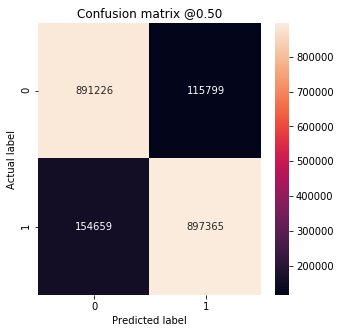

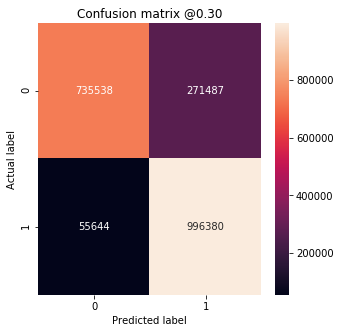

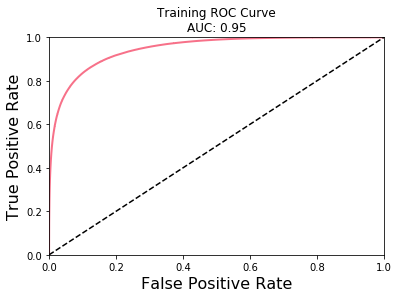

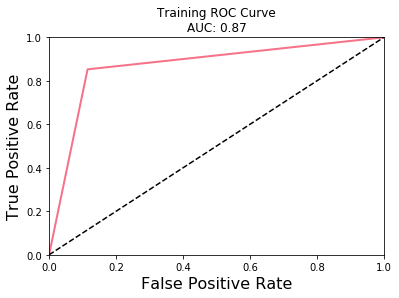

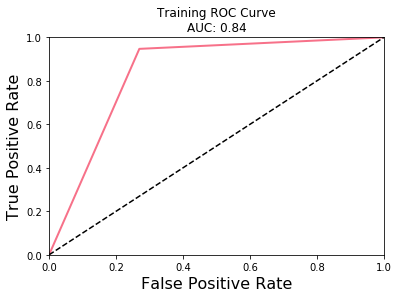

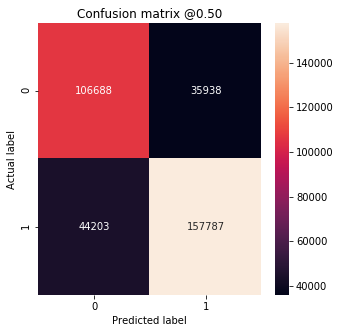

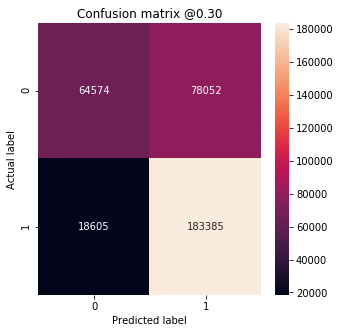

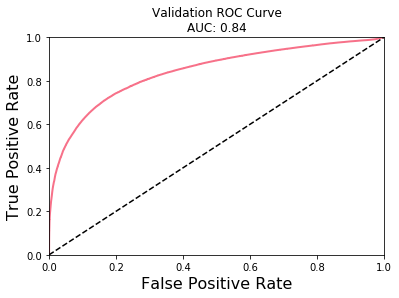

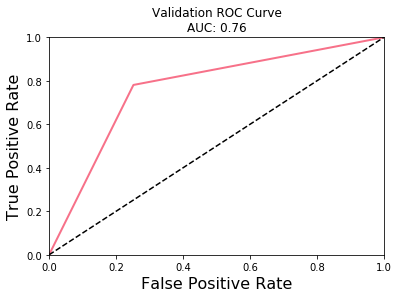

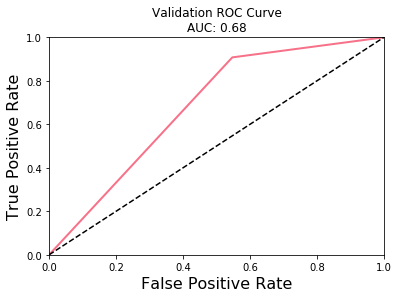

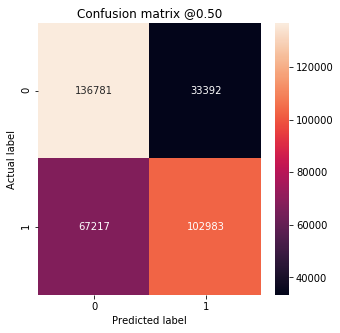

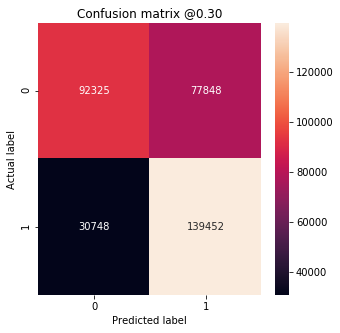

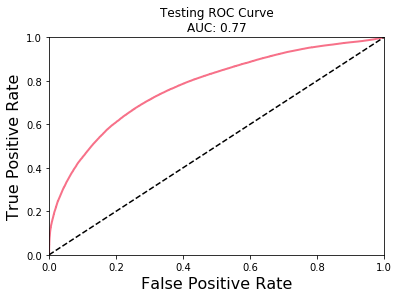

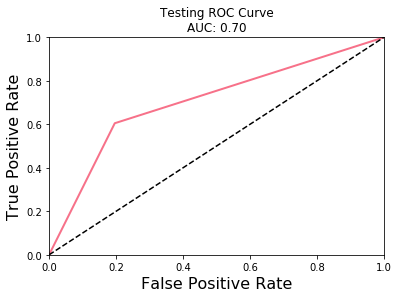

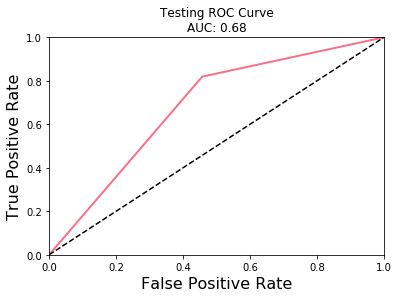

In [33]:
#features = ['median_daily_amount_same_size', 'last_amount_same_size',
 #      'last_amount_any_size', 'd_release_date_day', 'createdAt_hour']
features = old0_df_to_lgb.columns.drop(['drop10_60d','raise10_60d','amount'])  
y = 'drop10_60d'
y_pred_lgb_test1_down, importance1_down = \
call_lgb(old0_df_to_lgb, future0_df_to_lgb, future1_df_to_lgb,features,y, \
         note = 'top_10_shoes_all_features_64_leaf_all_features_drop_fold0')


In [36]:
importance1_down.head(10)

,Importance
median_daily_amount_same_size,1981
median_daily_amount_same_size_60d_rolling_avg,1561
d_release_date_day,1233
last_amount_same_size,1161
shoe_size,1083
product_name,613
color2,610
median_daily_amount_any_size_60d_rolling_avg,482
release_date_day,481
median_daily_amount_any_size_21d_rolling_avg,446


In [55]:
len(features)

55

In [54]:
features

Index(['model', 'color1', 'color2', 'product_name', 'shoe_size',
       'last_amount_same_size', 'median_daily_amount_same_size',
       'median_daily_amount_same_size_3d_rolling_avg',
       'median_daily_amount_same_size_5d_rolling_avg',
       'median_daily_amount_same_size_7d_rolling_avg',
       'median_daily_amount_same_size_14d_rolling_avg',
       'median_daily_amount_same_size_21d_rolling_avg',
       'median_daily_amount_same_size_30d_rolling_avg',
       'median_daily_amount_same_size_60d_rolling_avg', 'last_amount_any_size',
       'last_shoe_size_any_size', 'median_daily_amount_any_size',
       'median_daily_amount_any_size_3d_rolling_avg',
       'median_daily_amount_any_size_5d_rolling_avg',
       'median_daily_amount_any_size_7d_rolling_avg',
       'median_daily_amount_any_size_14d_rolling_avg',
       'median_daily_amount_any_size_21d_rolling_avg',
       'median_daily_amount_any_size_30d_rolling_avg',
       'median_daily_amount_any_size_60d_rolling_avg', 'createdA

[1]	training's auc: 0.788492	valid_1's auc: 0.560322
Training until validation scores don't improve for 20 rounds
[2]	training's auc: 0.810488	valid_1's auc: 0.594379
[3]	training's auc: 0.825214	valid_1's auc: 0.615715
[4]	training's auc: 0.829502	valid_1's auc: 0.626803
[5]	training's auc: 0.836816	valid_1's auc: 0.639388
[6]	training's auc: 0.842295	valid_1's auc: 0.644513
[7]	training's auc: 0.847707	valid_1's auc: 0.658052
[8]	training's auc: 0.85112	valid_1's auc: 0.66664
[9]	training's auc: 0.853683	valid_1's auc: 0.678758
[10]	training's auc: 0.855734	valid_1's auc: 0.682955
[11]	training's auc: 0.857482	valid_1's auc: 0.689168
[12]	training's auc: 0.860365	valid_1's auc: 0.693145
[13]	training's auc: 0.862208	valid_1's auc: 0.698367
[14]	training's auc: 0.86413	valid_1's auc: 0.703282
[15]	training's auc: 0.865475	valid_1's auc: 0.705316
[16]	training's auc: 0.867115	valid_1's auc: 0.708236
[17]	training's auc: 0.869167	valid_1's auc: 0.71254
[18]	training's auc: 0.871835	vali

[152]	training's auc: 0.936159	valid_1's auc: 0.785978
[153]	training's auc: 0.936311	valid_1's auc: 0.785818
[154]	training's auc: 0.936457	valid_1's auc: 0.786182
[155]	training's auc: 0.936638	valid_1's auc: 0.78623
[156]	training's auc: 0.936783	valid_1's auc: 0.786361
[157]	training's auc: 0.936884	valid_1's auc: 0.786888
[158]	training's auc: 0.936982	valid_1's auc: 0.786888
[159]	training's auc: 0.937063	valid_1's auc: 0.787244
[160]	training's auc: 0.937203	valid_1's auc: 0.786827
[161]	training's auc: 0.937323	valid_1's auc: 0.786962
[162]	training's auc: 0.937499	valid_1's auc: 0.786984
[163]	training's auc: 0.937582	valid_1's auc: 0.787289
[164]	training's auc: 0.937676	valid_1's auc: 0.787293
[165]	training's auc: 0.937844	valid_1's auc: 0.787156
[166]	training's auc: 0.937948	valid_1's auc: 0.787543
[167]	training's auc: 0.93808	valid_1's auc: 0.786983
[168]	training's auc: 0.938164	valid_1's auc: 0.787236
[169]	training's auc: 0.938269	valid_1's auc: 0.787688
[170]	traini

[302]	training's auc: 0.948807	valid_1's auc: 0.7924
[303]	training's auc: 0.948846	valid_1's auc: 0.792404
[304]	training's auc: 0.94889	valid_1's auc: 0.792418
[305]	training's auc: 0.948916	valid_1's auc: 0.792402
[306]	training's auc: 0.948952	valid_1's auc: 0.792513
[307]	training's auc: 0.948989	valid_1's auc: 0.792555
[308]	training's auc: 0.949023	valid_1's auc: 0.792424
[309]	training's auc: 0.949087	valid_1's auc: 0.792431
[310]	training's auc: 0.949122	valid_1's auc: 0.792428
[311]	training's auc: 0.949171	valid_1's auc: 0.792486
[312]	training's auc: 0.94924	valid_1's auc: 0.792548
[313]	training's auc: 0.949291	valid_1's auc: 0.792662
[314]	training's auc: 0.94937	valid_1's auc: 0.792749
[315]	training's auc: 0.949426	valid_1's auc: 0.792695
[316]	training's auc: 0.949478	valid_1's auc: 0.792781
[317]	training's auc: 0.949533	valid_1's auc: 0.792701
[318]	training's auc: 0.949609	valid_1's auc: 0.792733
[319]	training's auc: 0.949662	valid_1's auc: 0.79273
[320]	training's

[452]	training's auc: 0.95477	valid_1's auc: 0.795586
[453]	training's auc: 0.954788	valid_1's auc: 0.795677
[454]	training's auc: 0.954813	valid_1's auc: 0.795681
[455]	training's auc: 0.954852	valid_1's auc: 0.795635
[456]	training's auc: 0.954878	valid_1's auc: 0.795814
[457]	training's auc: 0.954913	valid_1's auc: 0.795759
[458]	training's auc: 0.954941	valid_1's auc: 0.795851
[459]	training's auc: 0.954959	valid_1's auc: 0.795912
[460]	training's auc: 0.95499	valid_1's auc: 0.79603
[461]	training's auc: 0.955032	valid_1's auc: 0.796232
[462]	training's auc: 0.955081	valid_1's auc: 0.796228
[463]	training's auc: 0.955125	valid_1's auc: 0.796392
[464]	training's auc: 0.955144	valid_1's auc: 0.796479
[465]	training's auc: 0.955159	valid_1's auc: 0.796484
[466]	training's auc: 0.955198	valid_1's auc: 0.796484
[467]	training's auc: 0.955243	valid_1's auc: 0.796566
[468]	training's auc: 0.955274	valid_1's auc: 0.796614
[469]	training's auc: 0.955321	valid_1's auc: 0.796733
[470]	trainin

[602]	training's auc: 0.958907	valid_1's auc: 0.80006
[603]	training's auc: 0.958934	valid_1's auc: 0.800102
[604]	training's auc: 0.958944	valid_1's auc: 0.800119
[605]	training's auc: 0.958971	valid_1's auc: 0.80012
[606]	training's auc: 0.95899	valid_1's auc: 0.800128
[607]	training's auc: 0.959015	valid_1's auc: 0.800121
[608]	training's auc: 0.959038	valid_1's auc: 0.800169
[609]	training's auc: 0.959065	valid_1's auc: 0.800312
[610]	training's auc: 0.959079	valid_1's auc: 0.800305
[611]	training's auc: 0.959091	valid_1's auc: 0.800315
[612]	training's auc: 0.959115	valid_1's auc: 0.800304
[613]	training's auc: 0.959132	valid_1's auc: 0.800363
[614]	training's auc: 0.959145	valid_1's auc: 0.800391
[615]	training's auc: 0.959172	valid_1's auc: 0.800391
[616]	training's auc: 0.959199	valid_1's auc: 0.800301
[617]	training's auc: 0.959209	valid_1's auc: 0.800311
[618]	training's auc: 0.959223	valid_1's auc: 0.800346
[619]	training's auc: 0.959245	valid_1's auc: 0.800332
[620]	trainin

[752]	training's auc: 0.961825	valid_1's auc: 0.801758
[753]	training's auc: 0.961846	valid_1's auc: 0.801795
[754]	training's auc: 0.961852	valid_1's auc: 0.801782
[755]	training's auc: 0.961859	valid_1's auc: 0.801782
[756]	training's auc: 0.961879	valid_1's auc: 0.80179
[757]	training's auc: 0.961889	valid_1's auc: 0.801725
[758]	training's auc: 0.961916	valid_1's auc: 0.801721
[759]	training's auc: 0.961942	valid_1's auc: 0.801697
[760]	training's auc: 0.961962	valid_1's auc: 0.801673
[761]	training's auc: 0.961976	valid_1's auc: 0.801736
[762]	training's auc: 0.961991	valid_1's auc: 0.801741
[763]	training's auc: 0.962002	valid_1's auc: 0.801767
[764]	training's auc: 0.962019	valid_1's auc: 0.801776
[765]	training's auc: 0.962034	valid_1's auc: 0.801807
[766]	training's auc: 0.962042	valid_1's auc: 0.801812
[767]	training's auc: 0.96207	valid_1's auc: 0.801814
[768]	training's auc: 0.962084	valid_1's auc: 0.801745
[769]	training's auc: 0.962103	valid_1's auc: 0.801791
[770]	traini

top_10_shoes_all_features_64_all_featueres_drop_fold1 
 validation ROC AUC: 0.7075630925128291
True Negatives:  132184
False Positives:  37989
False Negatives:  54926
True Positives:  115274
Total Actual Positives:  170200
True Negatives:  97545
False Positives:  72628
False Negatives:  26906
True Positives:  143294
Total Actual Positives:  170200
top_10_shoes_all_features_64_all_featueres_drop_fold1 
 testing ROC AUC: 0.6482224001910776
True Negatives:  118970
False Positives:  58068
False Negatives:  91756
True Positives:  248579
Total Actual Positives:  340335
True Negatives:  79358
False Positives:  97680
False Negatives:  51666
True Positives:  288669
Total Actual Positives:  340335


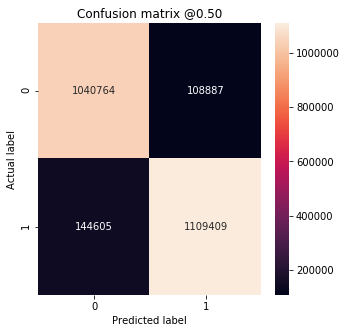

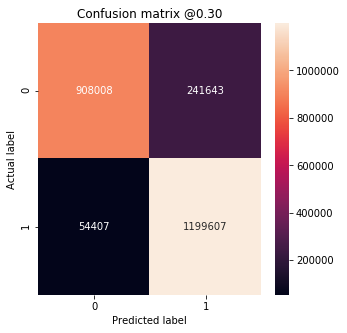

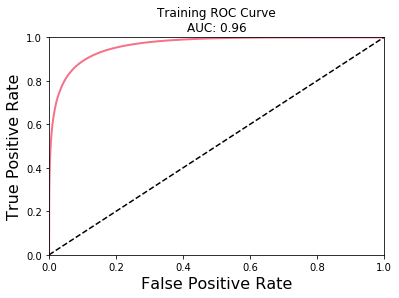

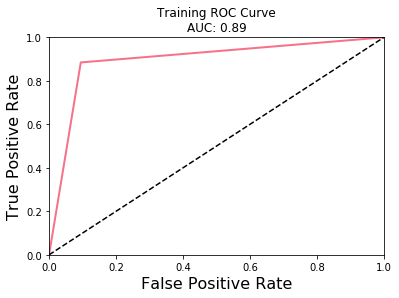

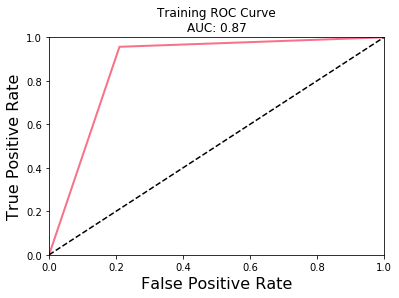

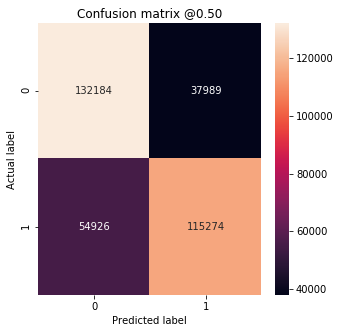

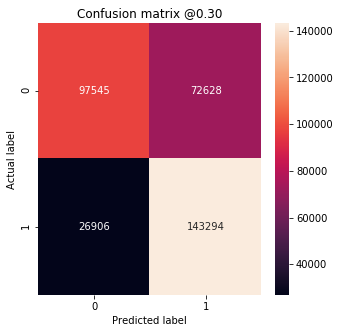

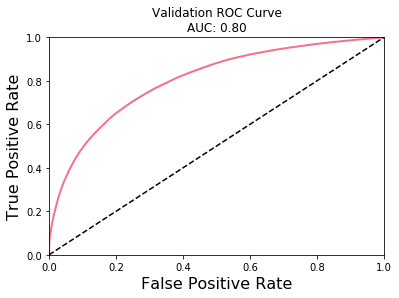

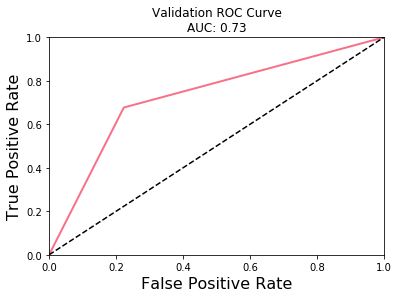

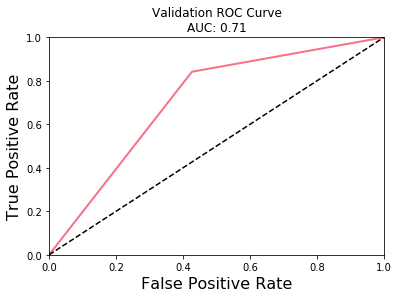

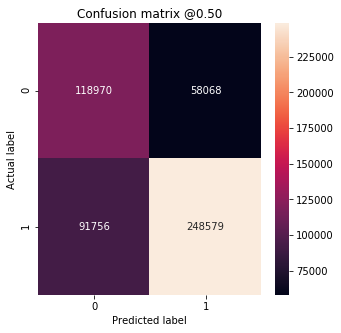

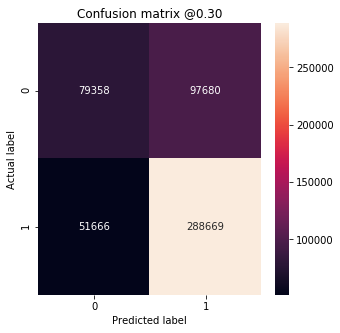

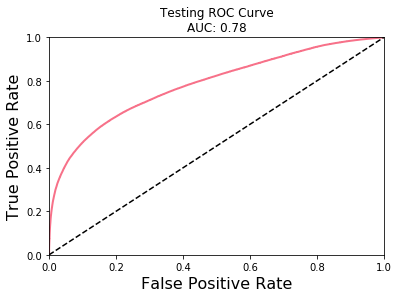

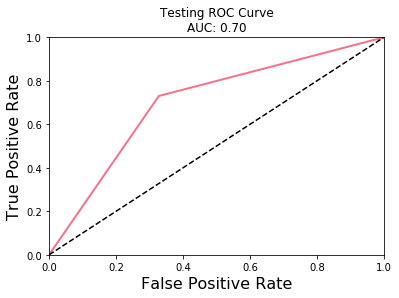

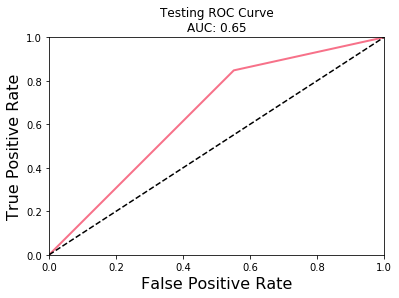

In [37]:
#features = old1_df_to_lgb.columns.drop('amount')
y_pred_lgb_test2_down, importance2_down = \
call_lgb(old1_df_to_lgb, future1_df_to_lgb, future2_df_to_lgb,features,y, \
         note = 'top_10_shoes_all_features_64_all_featueres_drop_fold1')


In [38]:
importance2_down.head(10)

,Importance
median_daily_amount_same_size,4901
shoe_size,4536
last_amount_same_size,4053
d_release_date_day,4037
median_daily_amount_same_size_60d_rolling_avg,4025
color2,1962
median_daily_amount_any_size_60d_rolling_avg,1722
product_name,1594
median_daily_amount_same_size_30d_rolling_avg,1593
median_daily_amount_any_size_14d_rolling_avg,1532


[1]	training's auc: 0.78768	valid_1's auc: 0.675303
Training until validation scores don't improve for 20 rounds
[2]	training's auc: 0.802435	valid_1's auc: 0.695314
[3]	training's auc: 0.809505	valid_1's auc: 0.703092
[4]	training's auc: 0.814974	valid_1's auc: 0.70634
[5]	training's auc: 0.827719	valid_1's auc: 0.716914
[6]	training's auc: 0.83574	valid_1's auc: 0.72087
[7]	training's auc: 0.840775	valid_1's auc: 0.725539
[8]	training's auc: 0.84466	valid_1's auc: 0.72882
[9]	training's auc: 0.847762	valid_1's auc: 0.731799
[10]	training's auc: 0.850351	valid_1's auc: 0.731161
[11]	training's auc: 0.85222	valid_1's auc: 0.73519
[12]	training's auc: 0.853826	valid_1's auc: 0.737393
[13]	training's auc: 0.856175	valid_1's auc: 0.739441
[14]	training's auc: 0.857914	valid_1's auc: 0.742155
[15]	training's auc: 0.859636	valid_1's auc: 0.741851
[16]	training's auc: 0.861752	valid_1's auc: 0.744092
[17]	training's auc: 0.863728	valid_1's auc: 0.743231
[18]	training's auc: 0.865535	valid_1'

[152]	training's auc: 0.931416	valid_1's auc: 0.778395
[153]	training's auc: 0.931586	valid_1's auc: 0.778716
[154]	training's auc: 0.93171	valid_1's auc: 0.778797
[155]	training's auc: 0.931898	valid_1's auc: 0.778916
[156]	training's auc: 0.932008	valid_1's auc: 0.778918
[157]	training's auc: 0.932164	valid_1's auc: 0.779543
[158]	training's auc: 0.932319	valid_1's auc: 0.779423
[159]	training's auc: 0.932479	valid_1's auc: 0.779702
[160]	training's auc: 0.932609	valid_1's auc: 0.779659
[161]	training's auc: 0.932734	valid_1's auc: 0.779617
[162]	training's auc: 0.932855	valid_1's auc: 0.779804
[163]	training's auc: 0.93302	valid_1's auc: 0.779922
[164]	training's auc: 0.933179	valid_1's auc: 0.78009
[165]	training's auc: 0.933348	valid_1's auc: 0.780202
[166]	training's auc: 0.933483	valid_1's auc: 0.778647
[167]	training's auc: 0.933635	valid_1's auc: 0.778985
[168]	training's auc: 0.933786	valid_1's auc: 0.779204
[169]	training's auc: 0.933907	valid_1's auc: 0.779969
[170]	trainin

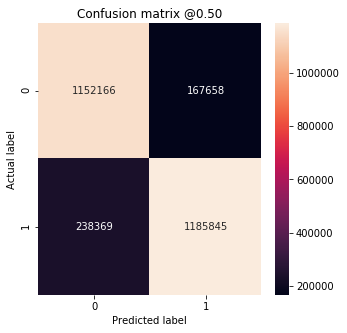

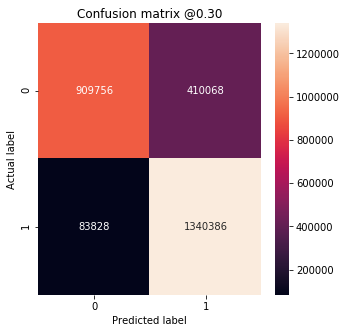

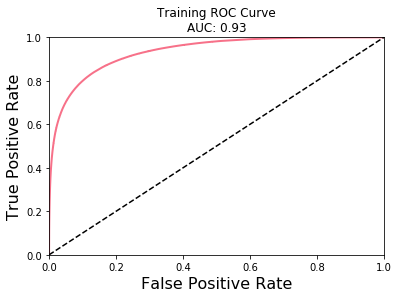

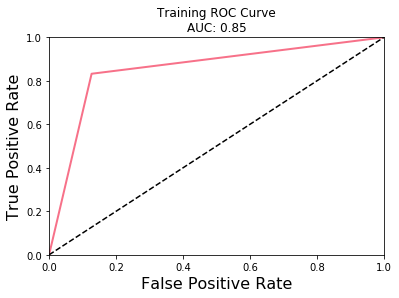

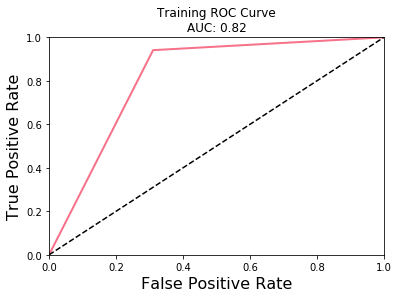

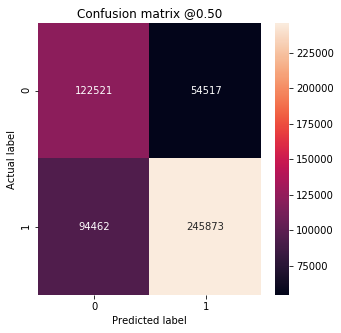

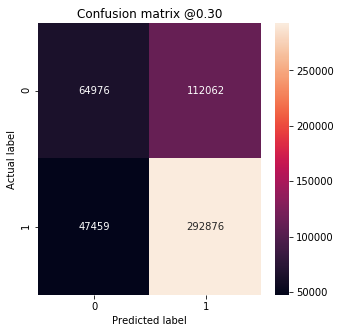

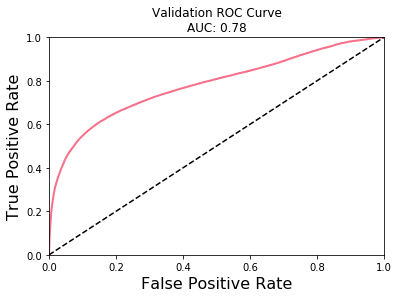

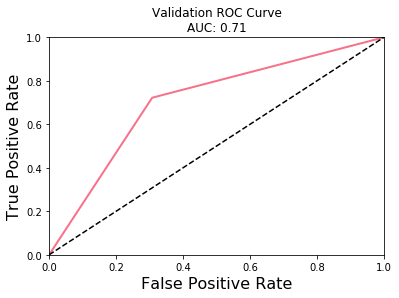

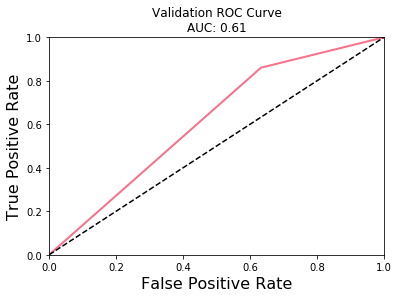

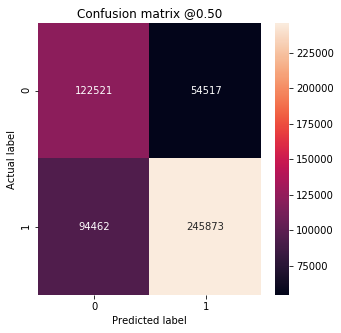

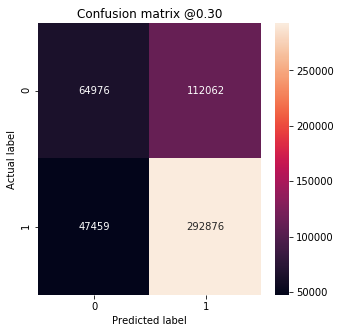

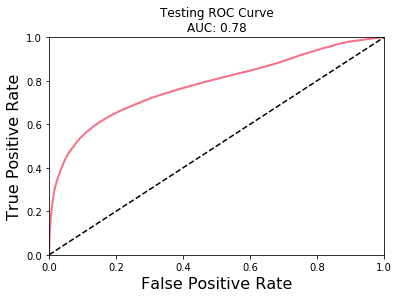

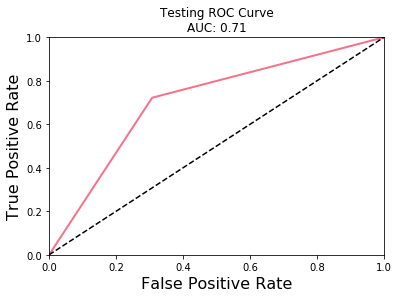

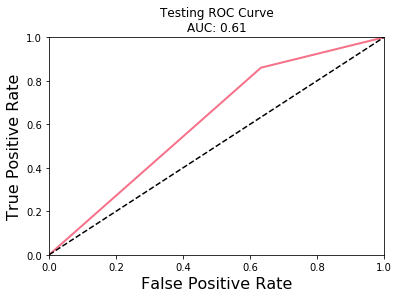

In [39]:
#features = old2_df_to_lgb.columns.drop('amount')
_, importance3_down = \
call_lgb(old2_df_to_lgb, future2_df_to_lgb, future2_df_to_lgb,features,y, \
         note = 'top_10_shoes_all_features_64_all_features_drop_fold2')

In [42]:
print(len(old0), len(future0))
print(len(old1), len(future1))
print(len(old2), len(future2))
#everything = pd.read_csv('all_trans_and_shoe.csv')
#print(len(everything))

2059049 344616
2403665 340373
2744038 517373


[1]	training's auc: 0.914034	valid_1's auc: 0.825593
Training until validation scores don't improve for 20 rounds
[2]	training's auc: 0.922312	valid_1's auc: 0.838655
[3]	training's auc: 0.926326	valid_1's auc: 0.845657
[4]	training's auc: 0.931474	valid_1's auc: 0.85023
[5]	training's auc: 0.932827	valid_1's auc: 0.853285
[6]	training's auc: 0.934485	valid_1's auc: 0.851134
[7]	training's auc: 0.936287	valid_1's auc: 0.853496
[8]	training's auc: 0.937936	valid_1's auc: 0.861453
[9]	training's auc: 0.93989	valid_1's auc: 0.862059
[10]	training's auc: 0.940978	valid_1's auc: 0.867175
[11]	training's auc: 0.943425	valid_1's auc: 0.867813
[12]	training's auc: 0.945151	valid_1's auc: 0.867391
[13]	training's auc: 0.946091	valid_1's auc: 0.867122
[14]	training's auc: 0.947216	valid_1's auc: 0.867823
[15]	training's auc: 0.947672	valid_1's auc: 0.869444
[16]	training's auc: 0.948985	valid_1's auc: 0.871785
[17]	training's auc: 0.950111	valid_1's auc: 0.871162
[18]	training's auc: 0.952108	va

top_10_shoes_all_features_64_leaf_clf_all_features_raise_fold0 
 training ROC AUC: 0.9290487837637745
top_10_shoes_all_features_64_leaf_clf_all_features_raise_fold0 
 training ROC AUC: 0.9196791752423853
True Negatives:  466643
False Positives:  20084
False Negatives:  158237
True Positives:  1414085
Total Actual Positives:  1572322
True Negatives:  436395
False Positives:  50332
False Negatives:  89988
True Positives:  1482334
Total Actual Positives:  1572322
top_10_shoes_all_features_64_leaf_clf_all_features_raise_fold0 
 validation ROC AUC: 0.7904721503883843
True Negatives:  85821
False Positives:  13706
False Negatives:  51129
True Positives:  193960
Total Actual Positives:  245089
True Negatives:  69642
False Positives:  29885
False Negatives:  29113
True Positives:  215976
Total Actual Positives:  245089
top_10_shoes_all_features_64_leaf_clf_all_features_raise_fold0 
 testing ROC AUC: 0.7811169865647851
True Negatives:  54111
False Positives:  10432
False Negatives:  49580
True 

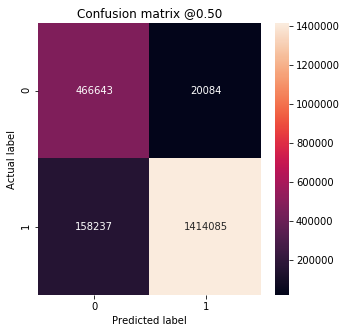

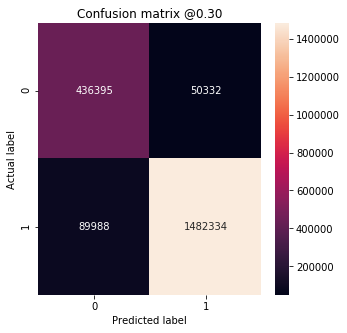

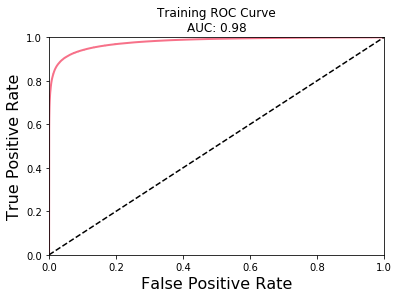

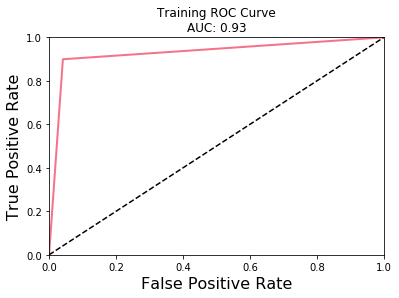

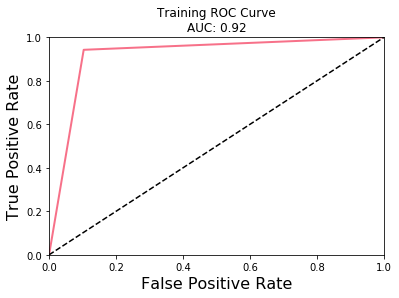

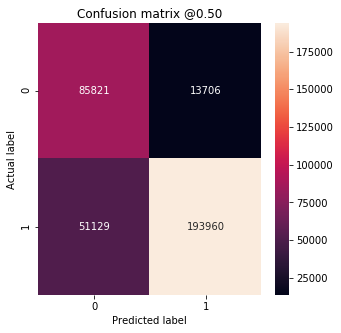

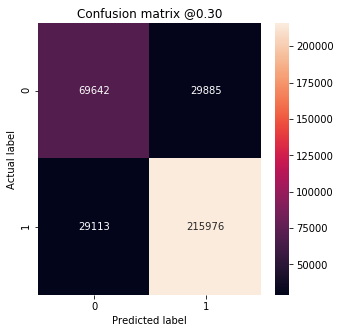

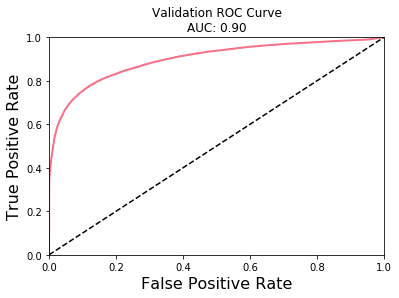

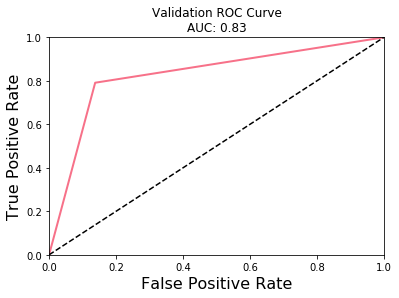

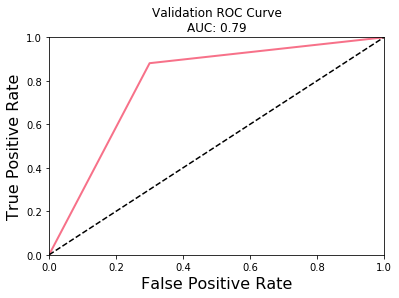

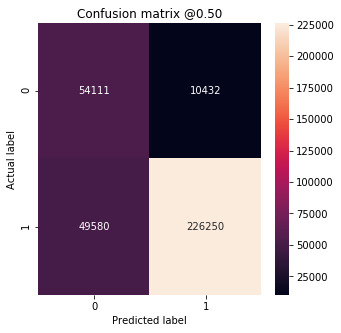

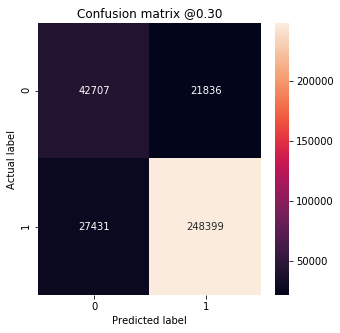

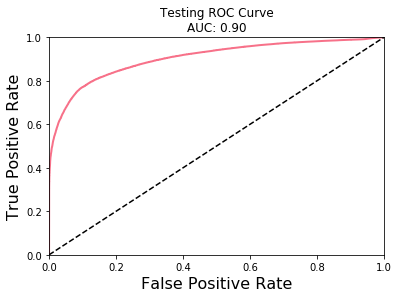

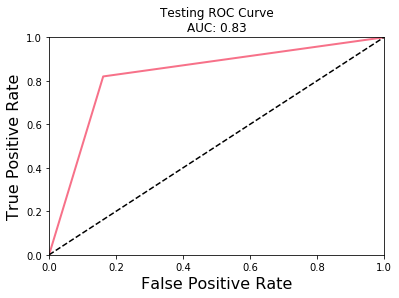

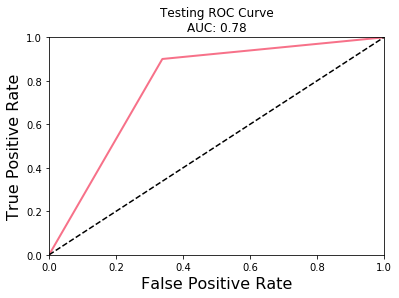

In [43]:
features = old0_df_to_lgb.columns.drop(['drop10_60d','raise10_60d','amount'])  
y = 'raise10_60d'
y_pred_lgb_test1_up, importance1_up = \
call_lgb(old0_df_to_lgb, future0_df_to_lgb, future1_df_to_lgb,features,y, \
         note = 'top_10_shoes_all_features_64_leaf_clf_all_features_raise_fold0')


In [44]:
importance1_up.head(5)

,Importance
median_daily_amount_same_size_60d_rolling_avg,1670
median_daily_amount_same_size,1540
d_release_date_day,577
shoe_size,394
last_amount_same_size,387


[1]	training's auc: 0.912213	valid_1's auc: 0.831152
Training until validation scores don't improve for 20 rounds
[2]	training's auc: 0.918353	valid_1's auc: 0.84664
[3]	training's auc: 0.921997	valid_1's auc: 0.850727
[4]	training's auc: 0.924905	valid_1's auc: 0.855526
[5]	training's auc: 0.926443	valid_1's auc: 0.857231
[6]	training's auc: 0.928498	valid_1's auc: 0.859642
[7]	training's auc: 0.931405	valid_1's auc: 0.857313
[8]	training's auc: 0.933514	valid_1's auc: 0.859023
[9]	training's auc: 0.936766	valid_1's auc: 0.85576
[10]	training's auc: 0.937606	valid_1's auc: 0.857695
[11]	training's auc: 0.938529	valid_1's auc: 0.859333
[12]	training's auc: 0.940626	valid_1's auc: 0.862205
[13]	training's auc: 0.941664	valid_1's auc: 0.864354
[14]	training's auc: 0.942642	valid_1's auc: 0.865932
[15]	training's auc: 0.944814	valid_1's auc: 0.869174
[16]	training's auc: 0.946547	valid_1's auc: 0.87524
[17]	training's auc: 0.948201	valid_1's auc: 0.876713
[18]	training's auc: 0.949194	val

[153]	training's auc: 0.977916	valid_1's auc: 0.919067
[154]	training's auc: 0.977947	valid_1's auc: 0.919195
[155]	training's auc: 0.978011	valid_1's auc: 0.919268
[156]	training's auc: 0.978043	valid_1's auc: 0.919276
[157]	training's auc: 0.978074	valid_1's auc: 0.919308
[158]	training's auc: 0.978115	valid_1's auc: 0.919338
[159]	training's auc: 0.978141	valid_1's auc: 0.919421
[160]	training's auc: 0.978201	valid_1's auc: 0.919506
[161]	training's auc: 0.978268	valid_1's auc: 0.919506
[162]	training's auc: 0.978295	valid_1's auc: 0.919571
[163]	training's auc: 0.978347	valid_1's auc: 0.919618
[164]	training's auc: 0.978377	valid_1's auc: 0.919618
[165]	training's auc: 0.978426	valid_1's auc: 0.919395
[166]	training's auc: 0.978481	valid_1's auc: 0.919368
[167]	training's auc: 0.978508	valid_1's auc: 0.919405
[168]	training's auc: 0.978553	valid_1's auc: 0.919333
[169]	training's auc: 0.978575	valid_1's auc: 0.919398
[170]	training's auc: 0.978609	valid_1's auc: 0.919404
[171]	trai

[303]	training's auc: 0.98213	valid_1's auc: 0.922478
[304]	training's auc: 0.982152	valid_1's auc: 0.922502
[305]	training's auc: 0.982182	valid_1's auc: 0.9225
[306]	training's auc: 0.982201	valid_1's auc: 0.922518
[307]	training's auc: 0.982218	valid_1's auc: 0.922561
[308]	training's auc: 0.982235	valid_1's auc: 0.922561
[309]	training's auc: 0.982259	valid_1's auc: 0.92261
[310]	training's auc: 0.982283	valid_1's auc: 0.922612
[311]	training's auc: 0.982307	valid_1's auc: 0.922589
[312]	training's auc: 0.982328	valid_1's auc: 0.922582
[313]	training's auc: 0.982349	valid_1's auc: 0.922583
[314]	training's auc: 0.982365	valid_1's auc: 0.922571
[315]	training's auc: 0.982374	valid_1's auc: 0.922554
[316]	training's auc: 0.982385	valid_1's auc: 0.922551
[317]	training's auc: 0.982415	valid_1's auc: 0.922551
[318]	training's auc: 0.982436	valid_1's auc: 0.922559
[319]	training's auc: 0.982454	valid_1's auc: 0.922654
[320]	training's auc: 0.982471	valid_1's auc: 0.922666
[321]	training

[453]	training's auc: 0.984294	valid_1's auc: 0.923345
[454]	training's auc: 0.984309	valid_1's auc: 0.92333
[455]	training's auc: 0.984315	valid_1's auc: 0.923343
[456]	training's auc: 0.984327	valid_1's auc: 0.923359
[457]	training's auc: 0.984337	valid_1's auc: 0.923355
[458]	training's auc: 0.984345	valid_1's auc: 0.923365
[459]	training's auc: 0.984356	valid_1's auc: 0.923365
[460]	training's auc: 0.984372	valid_1's auc: 0.923362
[461]	training's auc: 0.984383	valid_1's auc: 0.923394
[462]	training's auc: 0.984395	valid_1's auc: 0.923394
[463]	training's auc: 0.984404	valid_1's auc: 0.923383
[464]	training's auc: 0.984414	valid_1's auc: 0.923409
[465]	training's auc: 0.984423	valid_1's auc: 0.923418
[466]	training's auc: 0.984429	valid_1's auc: 0.923417
[467]	training's auc: 0.984434	valid_1's auc: 0.923427
[468]	training's auc: 0.98445	valid_1's auc: 0.923452
[469]	training's auc: 0.984468	valid_1's auc: 0.923458
[470]	training's auc: 0.984475	valid_1's auc: 0.923463
[471]	traini

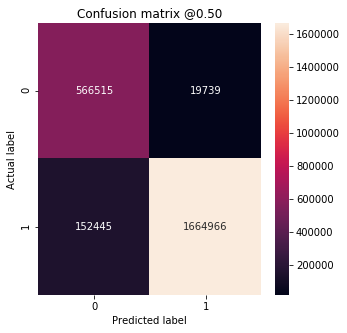

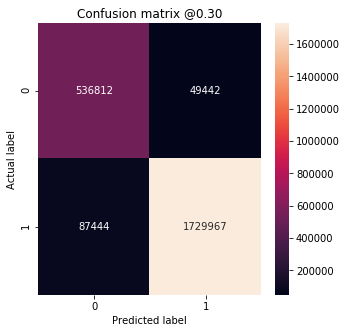

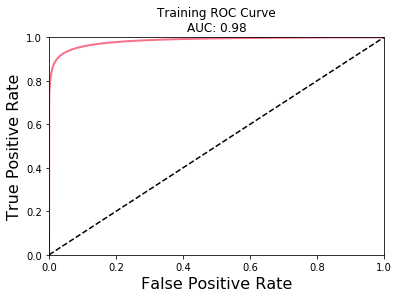

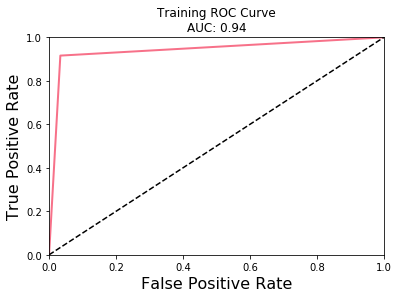

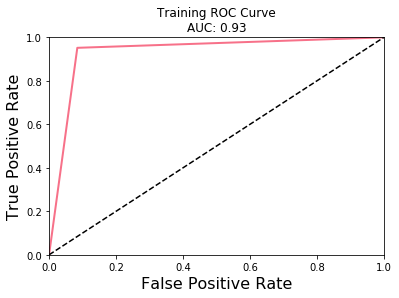

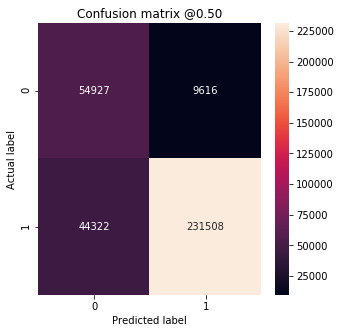

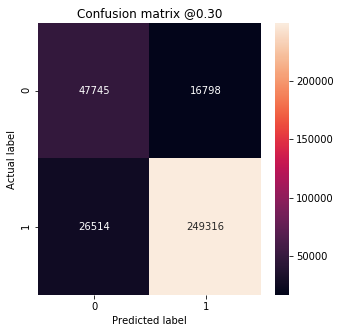

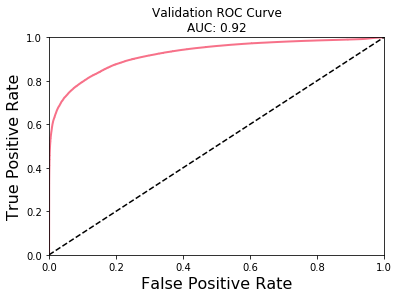

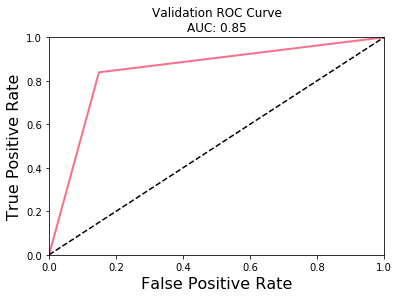

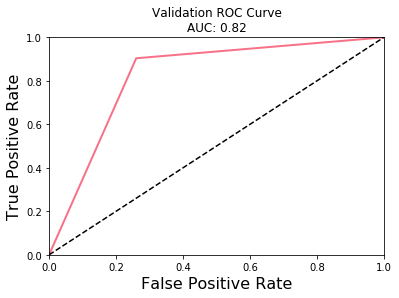

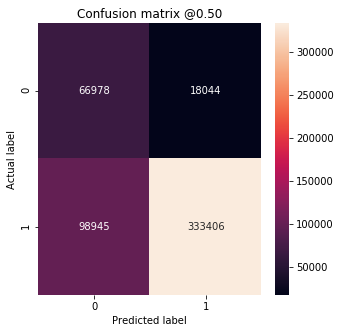

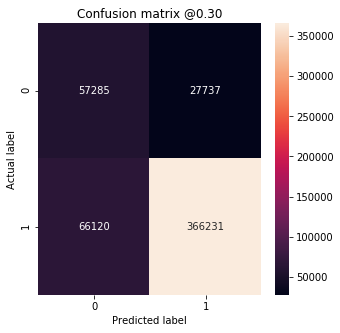

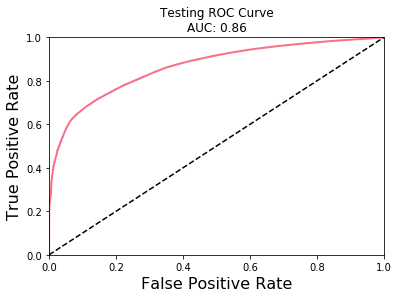

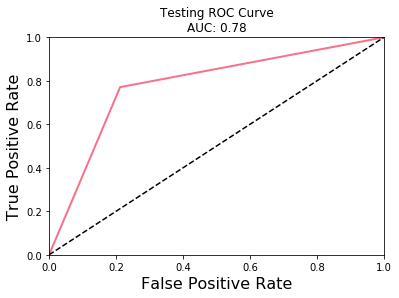

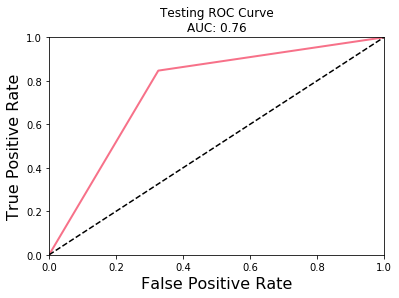

In [45]:
y_pred_lgb_test2_up, importance2_up = \
call_lgb(old1_df_to_lgb, future1_df_to_lgb, future2_df_to_lgb,features,y, \
         note = 'top_10_shoes_all_features_64_clf_all_featueres_raise_fold1')


[1]	training's auc: 0.901994	valid_1's auc: 0.719796
Training until validation scores don't improve for 20 rounds
[2]	training's auc: 0.911474	valid_1's auc: 0.727239
[3]	training's auc: 0.916098	valid_1's auc: 0.748784
[4]	training's auc: 0.921126	valid_1's auc: 0.762522
[5]	training's auc: 0.922542	valid_1's auc: 0.755397
[6]	training's auc: 0.926506	valid_1's auc: 0.766214
[7]	training's auc: 0.931816	valid_1's auc: 0.762755
[8]	training's auc: 0.933503	valid_1's auc: 0.764076
[9]	training's auc: 0.93486	valid_1's auc: 0.766157
[10]	training's auc: 0.936049	valid_1's auc: 0.763095
[11]	training's auc: 0.93728	valid_1's auc: 0.765522
[12]	training's auc: 0.940708	valid_1's auc: 0.777052
[13]	training's auc: 0.942241	valid_1's auc: 0.784203
[14]	training's auc: 0.943007	valid_1's auc: 0.78845
[15]	training's auc: 0.944489	valid_1's auc: 0.790605
[16]	training's auc: 0.946513	valid_1's auc: 0.795141
[17]	training's auc: 0.947121	valid_1's auc: 0.793505
[18]	training's auc: 0.948716	val

[152]	training's auc: 0.97675	valid_1's auc: 0.864778
[153]	training's auc: 0.976788	valid_1's auc: 0.864781
[154]	training's auc: 0.976827	valid_1's auc: 0.864906
[155]	training's auc: 0.976873	valid_1's auc: 0.864905
[156]	training's auc: 0.97692	valid_1's auc: 0.865028
[157]	training's auc: 0.976961	valid_1's auc: 0.865028
[158]	training's auc: 0.977001	valid_1's auc: 0.865062
[159]	training's auc: 0.977063	valid_1's auc: 0.865213
[160]	training's auc: 0.977131	valid_1's auc: 0.865267
[161]	training's auc: 0.977156	valid_1's auc: 0.865266
[162]	training's auc: 0.977181	valid_1's auc: 0.86527
[163]	training's auc: 0.977221	valid_1's auc: 0.865196
[164]	training's auc: 0.977253	valid_1's auc: 0.865197
[165]	training's auc: 0.977273	valid_1's auc: 0.865244
[166]	training's auc: 0.977305	valid_1's auc: 0.865281
[167]	training's auc: 0.977342	valid_1's auc: 0.865392
[168]	training's auc: 0.977382	valid_1's auc: 0.865456
[169]	training's auc: 0.977426	valid_1's auc: 0.865657
[170]	trainin

[302]	training's auc: 0.980951	valid_1's auc: 0.869682
[303]	training's auc: 0.980986	valid_1's auc: 0.869672
[304]	training's auc: 0.98101	valid_1's auc: 0.869685
[305]	training's auc: 0.981032	valid_1's auc: 0.869793
[306]	training's auc: 0.981048	valid_1's auc: 0.869884
[307]	training's auc: 0.981059	valid_1's auc: 0.869884
[308]	training's auc: 0.981083	valid_1's auc: 0.869998
[309]	training's auc: 0.981112	valid_1's auc: 0.870085
[310]	training's auc: 0.981143	valid_1's auc: 0.869735
[311]	training's auc: 0.981154	valid_1's auc: 0.869739
[312]	training's auc: 0.981183	valid_1's auc: 0.869717
[313]	training's auc: 0.981198	valid_1's auc: 0.869746
[314]	training's auc: 0.981217	valid_1's auc: 0.869759
[315]	training's auc: 0.981236	valid_1's auc: 0.869759
[316]	training's auc: 0.981255	valid_1's auc: 0.869584
[317]	training's auc: 0.981282	valid_1's auc: 0.869706
[318]	training's auc: 0.981295	valid_1's auc: 0.869907
[319]	training's auc: 0.981313	valid_1's auc: 0.870017
[320]	train

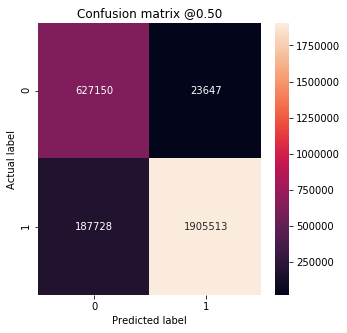

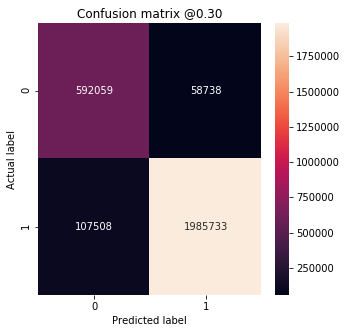

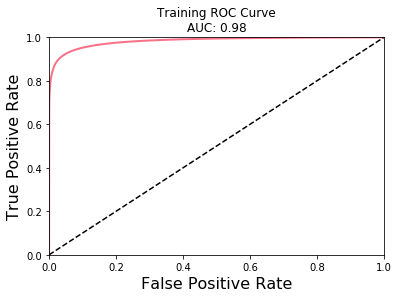

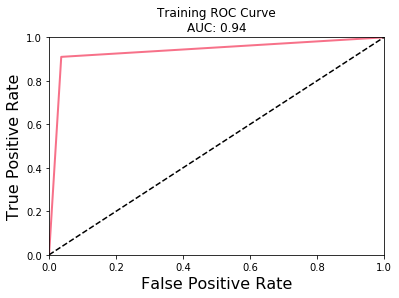

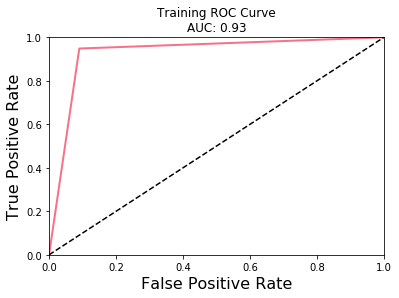

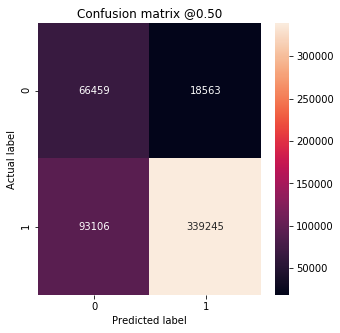

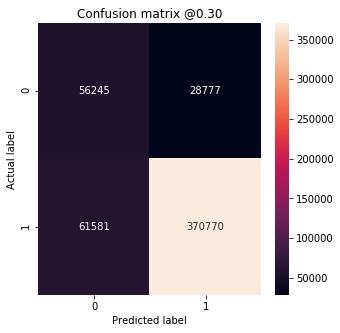

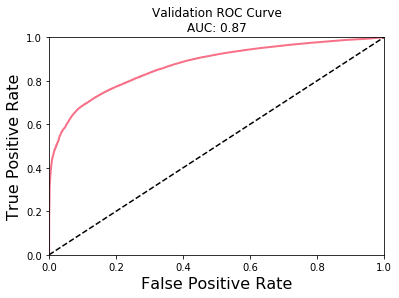

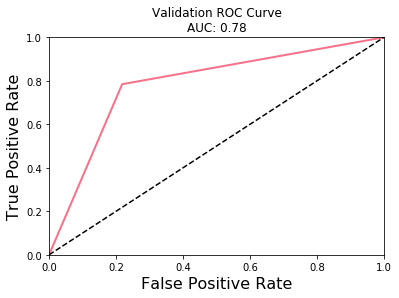

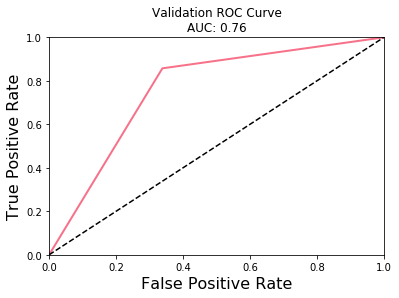

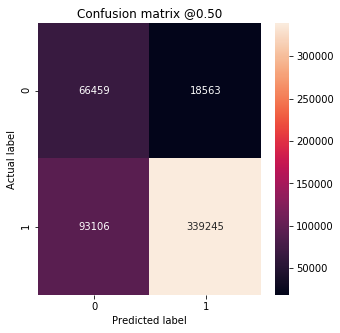

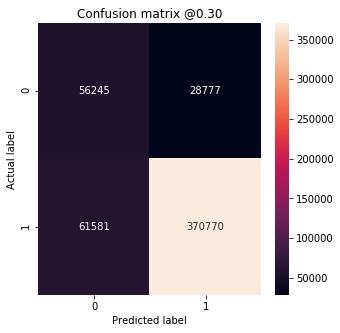

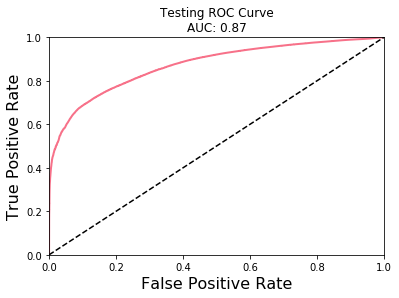

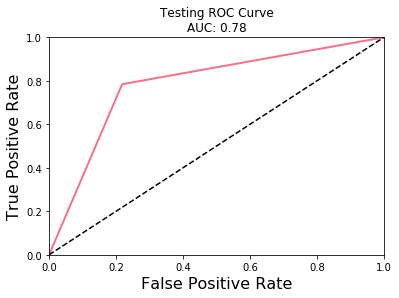

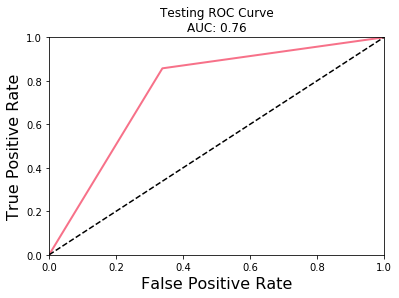

In [46]:
_, importance3 = \
call_lgb(old2_df_to_lgb, future2_df_to_lgb, future2_df_to_lgb,features,y, \
         note = 'top_10_shoes_all_features_64_6_features_raise_fold2')

In [47]:
for k in lbl_dict.keys():
    tmp = pd.DataFrame(columns = ['key','value'])
    tmp['key'] = lbl_dict[k].classes_
    tmp['value'] = range(len(lbl_dict[k].classes_))
    fname = (k+'_all_shoe_down10_up10.csv')
    tmp.to_csv(fname)

In [48]:
lbl_dict

{'model': LabelEncoder(),
 'product_name': LabelEncoder(),
 'color1': LabelEncoder(),
 'color2': LabelEncoder()}

In [49]:
model = pd.read_csv('model_all_shoe.csv')

In [50]:
model.head()

,Unnamed: 0,key,value
0,0,A Bathing Ape Bapesta,0
1,1,ACE 16 PureControl Ultra Boost,1
2,2,ASICS GT-II,2
3,3,ASICS Gel-Lyte III,3
4,4,Air Jordan 1 Mid,4


In [51]:
model[model['key'] == 'ASICS GT-II']['value'].iloc[0]

2

In [52]:
c1 = pd.read_csv('color1_all_shoe.csv')
c1[c1['key'] == 'white']['value'].iloc[0]

229

In [53]:
c1['key'].iloc[0]

'Agate Gray'